# Step 1 – Import Libraries and Load Dataset

We start by importing the required Python libraries and loading the Google Play Store dataset.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("googleplaystore.csv")

# Display shape and first few rows
print("Shape of dataset:", df.shape)
df.head()


Shape of dataset: (10841, 13)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


### Observation:
- The dataset has **10,841 rows** and **13 columns**.
- Columns include information about apps like `App`, `Category`, `Rating`, `Reviews`, `Size`, `Installs`, etc.
- Some columns (e.g., `Size`, `Installs`, `Price`) are stored as strings and will need cleaning.


# Step 2 – Missing Values Analysis

We check for missing values to understand data quality issues.


In [2]:
missing = df.isnull().sum().sort_values(ascending=False)
missing_pct = (missing/len(df))*100
missing_df = pd.DataFrame({"Missing Values": missing, "Percentage": missing_pct.round(2)})
missing_df


,Missing Values,Percentage
Rating,1474,13.60
Current Ver,8,0.07
Android Ver,2,0.02
Category,1,0.01
Type,1,0.01
Genres,1,0.01
Size,0,0.00
App,0,0.00
Reviews,0,0.00
Content Rating,0,0.00


### Observation:
- The `Rating` column has ~15% missing values.
- Columns like `Category`, `Type`, `Genres`, and `Android Ver` have very few missing values.
- We will handle missing values case-by-case (not drop everything blindly).


# Step 3 – Handle Duplicates

Some apps appear multiple times. We'll keep only the entry with the **highest number of reviews** (most reliable).


In [3]:
print("Duplicates before:", df.duplicated(subset="App").sum())
df = df.sort_values("Reviews", ascending=False).drop_duplicates("App")
print("Shape after removing duplicates:", df.shape)


Duplicates before: 1181
Shape after removing duplicates: (9660, 13)


### Observation:
- About **1,181 duplicate apps** were removed.  
- Now we have around **9,660 unique apps** for analysis.


# Step 4 – Cleaning Installs Column

The `Installs` column has strings like "1,000+", "5,000,000+".
We remove "+" and "," and convert it into integers.


In [4]:
df['Installs'] = df['Installs'].astype(str)
df['Installs'] = df['Installs'].str.replace('+', '', regex=False)
df['Installs'] = df['Installs'].str.replace(',', '', regex=False)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')


In [5]:
df[['App','Installs']].head()

,App,Installs
2544,Facebook,1000000000
381,WhatsApp Messenger,1000000000
2604,Instagram,1000000000
382,Messenger – Text and Video Chat for Free,1000000000
1879,Clash of Clans,100000000


### Observation:
- `Installs` is now numeric.  
- Example: "5,000,000+" → `5000000`.  
- This column can now be used for statistical analysis and visualization.


# Step 5 – Cleaning Price Column

The `Price` column has values like "$4.99".  
We remove the "$" symbol and convert to float.


In [6]:
df['Price'] = df['Price'].str.replace('$','', regex=False)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

df[['App','Price']].head()


,App,Price
2544,Facebook,0.0
381,WhatsApp Messenger,0.0
2604,Instagram,0.0
382,Messenger – Text and Video Chat for Free,0.0
1879,Clash of Clans,0.0


### Observation:
- `Price` is now numeric.  
- Free apps appear as **0**, paid apps have their price in USD.  
- Most apps are free; very few are paid.


# Step 6 – Cleaning Size Column

The `Size` column has values like "19M", "14k", or "Varies with device".  
We convert everything to **MB**:
- "19M" → 19  
- "14k" → 0.014 (MB)  
- "Varies with device" → NaN


In [7]:
def size_to_mb(x):
    if x == "Varies with device":
        return np.nan
    if isinstance(x, str):
        if "M" in x:
            return float(x.replace("M",""))
        elif "k" in x:
            return float(x.replace("k",""))/1024
    return np.nan

df['Size_MB'] = df['Size'].apply(size_to_mb)

df[['App','Size','Size_MB']].head()


,App,Size,Size_MB
2544,Facebook,Varies with device,NaN
381,WhatsApp Messenger,Varies with device,NaN
2604,Instagram,Varies with device,NaN
382,Messenger – Text and Video Chat for Free,Varies with device,NaN
1879,Clash of Clans,98M,98.0


### Observation:
- `Size` is now numeric (in MB).  
- Example: "14k" → 0.014 MB.  
- Many apps have `NaN` in size (because size varies with device).


# Step 7 – Final Cleaned Data Overview

Now we check dataset summary after cleaning key columns.


In [8]:
df[['Rating','Reviews','Installs','Price','Size_MB']].describe()


,Rating,Reviews,Installs,Price,Size_MB
count,8197.000000,9.660000e+03,9.660000e+03,9660.000000,8432.000000
mean,4.172990,2.167817e+05,7.797363e+06,1.097117,20.396011
std,0.536808,1.831337e+06,5.376700e+07,16.850750,21.828486
min,1.000000,0.000000e+00,0.000000e+00,0.000000,0.008301
25%,4.000000,2.500000e+01,1.000000e+03,0.000000,4.575000
50%,4.300000,9.690000e+02,1.000000e+05,0.000000,12.000000
75%,4.500000,2.944925e+04,1.000000e+06,0.000000,28.000000
max,5.000000,7.815831e+07,1.000000e+09,400.000000,100.000000


### Observation:
- `Reviews` and `Installs` are **highly skewed** (some apps have millions of installs, others very few).  
- `Rating` ranges mostly between 3.5 and 5.  
- `Price` median = 0 (most apps are free).  
- `Size_MB` varies a lot (some small KB apps, some hundreds of MB).  


# Step 8 – Visualization: Ratings Distribution

We visualize how ratings are distributed across apps.


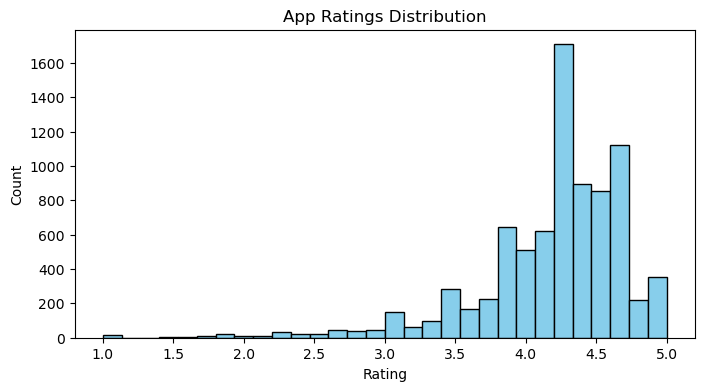

In [9]:
plt.figure(figsize=(8,4))
plt.hist(df['Rating'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title("App Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


### Observation:
- Ratings are **skewed to the right**.  
- Most apps are rated between **4.0 and 5.0**.  
- Very few apps have ratings below 3.0.


# Step 9 – Top Categories by Number of Apps

We check which categories have the most apps on the Google Play Store.


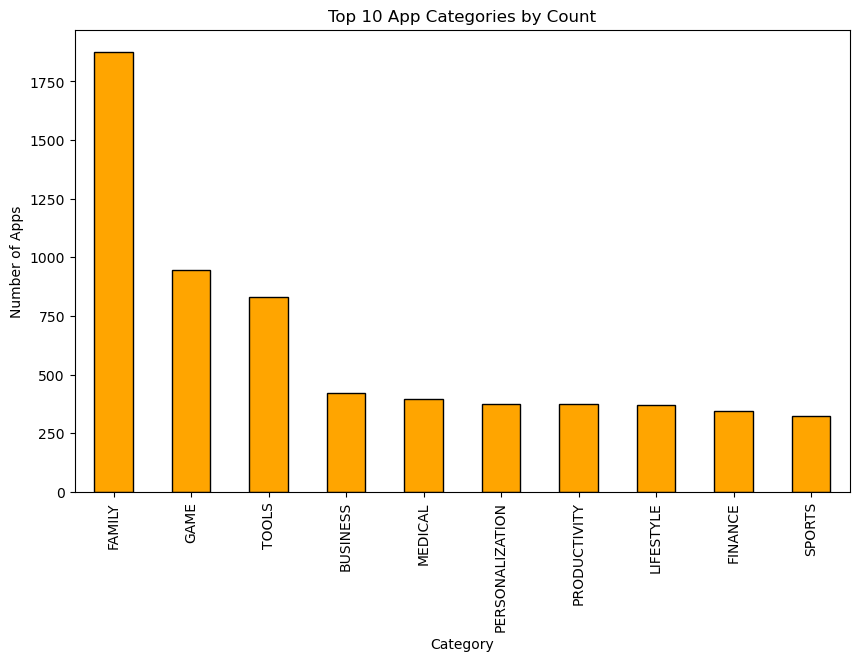

In [10]:
plt.figure(figsize=(10,6))
df['Category'].value_counts().head(10).plot(kind='bar', color='orange', edgecolor='black')
plt.title("Top 10 App Categories by Count")
plt.xlabel("Category")
plt.ylabel("Number of Apps")
plt.show()


### Observation:
- The most common categories are **Family**, **Game**, **Tools**, and **Medical**.  
- Categories like **Beauty** and **Comics** have fewer apps.  


# Step 10 – Categories with Most Installs

We calculate the total installs per category to see which categories are most popular among users.


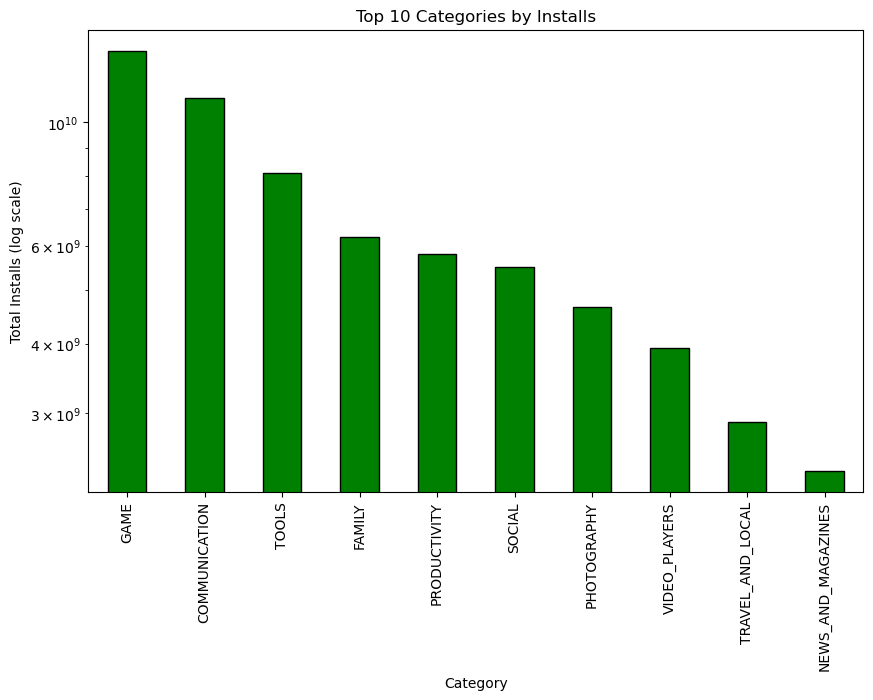

In [11]:
installs_per_cat = df.groupby('Category')['Installs'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
installs_per_cat.plot(kind='bar', color='green', edgecolor='black')
plt.title("Top 10 Categories by Installs")
plt.xlabel("Category")
plt.ylabel("Total Installs (log scale)")
plt.yscale('log')  # log scale because installs are huge
plt.show()


### Observation:
- **Games** dominate in total installs.  
- **Communication, Tools, Social, and Productivity** also have very high installs.  
- Niche categories (like Lifestyle, Education) have fewer installs comparatively.  


# Step 11 – Free vs Paid Apps

We check how many apps are free vs paid.


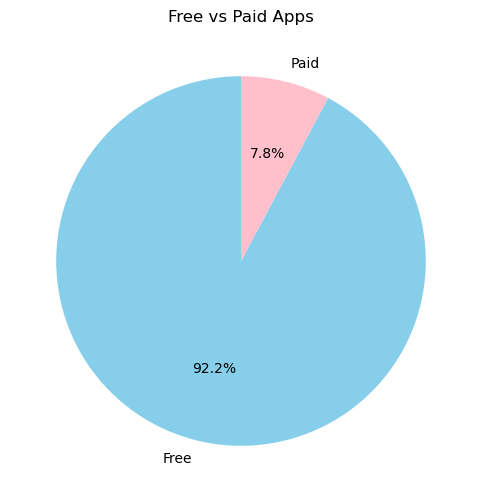

In [12]:
plt.figure(figsize=(6,6))
df['Type'].value_counts().plot.pie(autopct='%1.1f%%', colors=['skyblue','pink'], startangle=90)
plt.title("Free vs Paid Apps")
plt.ylabel("")
plt.show()


### Observation:
- Around **92% apps are Free**, and only **8% are Paid**.  
- Google Play Store is heavily dominated by free apps.  


# Step 12 – Installs: Free vs Paid

We compare the number of installs between Free and Paid apps.


C:\Users\Waqas\AppData\Local\Temp\ipykernel_15520\1357337126.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Type", y="Installs", data=df, showfliers=False, palette="Set2")


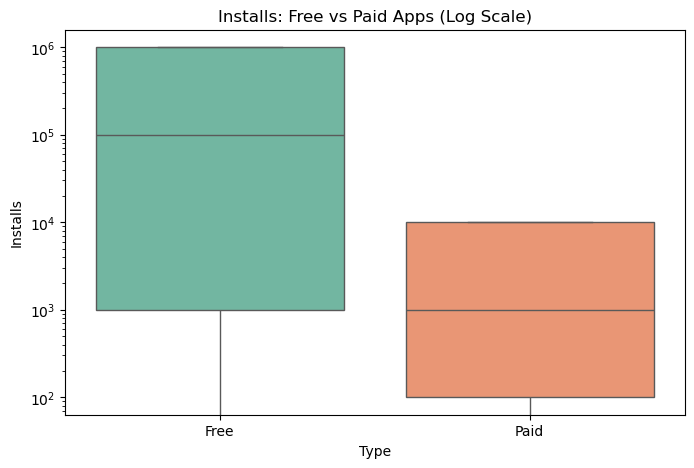

In [13]:
plt.figure(figsize=(8,5))
sns.boxplot(x="Type", y="Installs", data=df, showfliers=False, palette="Set2")
plt.yscale('log')
plt.title("Installs: Free vs Paid Apps (Log Scale)")
plt.show()


### Observation:
- Free apps get **much higher installs** than paid apps.  
- Paid apps rarely cross **1M+ installs**, while free apps often go into hundreds of millions.  


# Step 13 – Price Distribution of Paid Apps

We visualize the price range of paid apps.


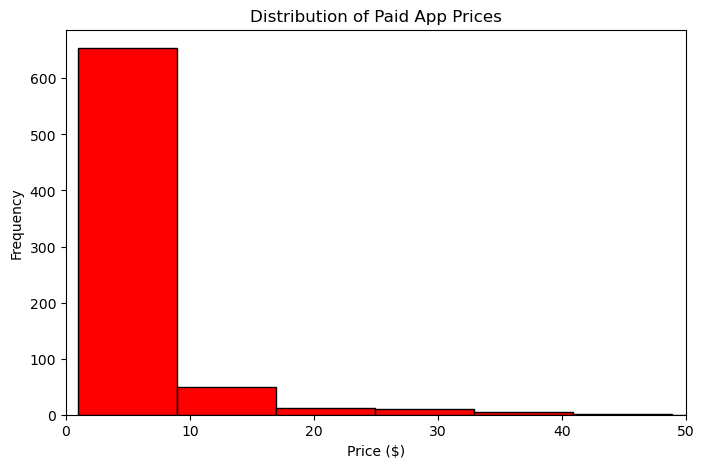

In [14]:
plt.figure(figsize=(8,5))
df[df['Price']>0]['Price'].plot.hist(bins=50, color='red', edgecolor='black')
plt.title("Distribution of Paid App Prices")
plt.xlabel("Price ($)")
plt.xlim(0,50)  # zoom into first $50 for better view
plt.show()


### Observation:
- Most paid apps are priced **under $20**.  
- Very few apps go beyond $50 (outliers exist, e.g., $300+ medical apps).  


# Step 14 – App Size vs Rating

We check if app size (MB) has any relationship with ratings.


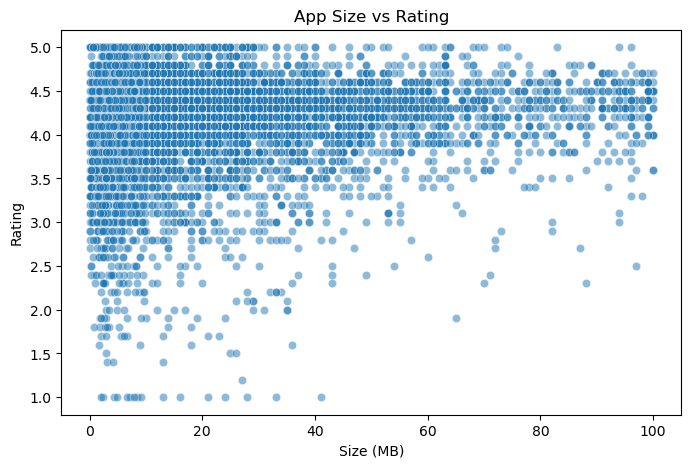

In [15]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="Size_MB", y="Rating", data=df, alpha=0.5)
plt.title("App Size vs Rating")
plt.xlabel("Size (MB)")
plt.ylabel("Rating")
plt.show()


### Observation:
- No clear correlation between app size and rating.  
- Both small and large apps get good ratings.  
- Ratings mostly cluster around 4–5 regardless of size.  


# Step 15 – Reviews vs Rating

We explore whether the number of reviews correlates with app ratings.


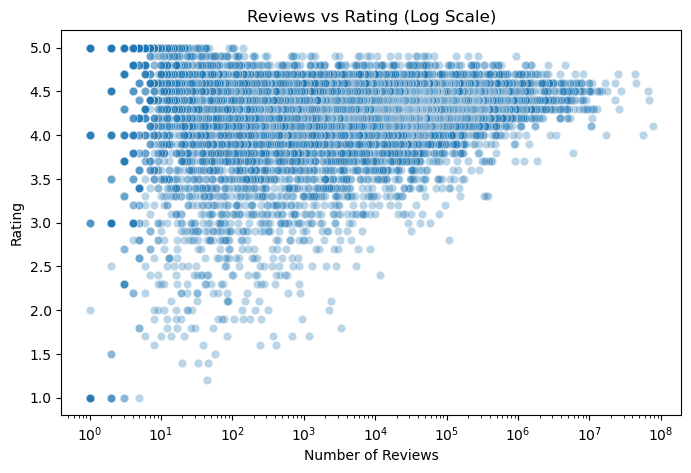

In [16]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="Reviews", y="Rating", data=df, alpha=0.3)
plt.xscale("log")
plt.title("Reviews vs Rating (Log Scale)")
plt.xlabel("Number of Reviews")
plt.ylabel("Rating")
plt.show()


### Observation:
- Apps with **more reviews** generally maintain ratings around **4–5**.  
- Very few popular apps (high reviews) have ratings below 3.  
- Suggests that **good apps stay consistently high-rated even with more users**.  


# Step 16 – Correlation Heatmap

We check correlations between numeric features.


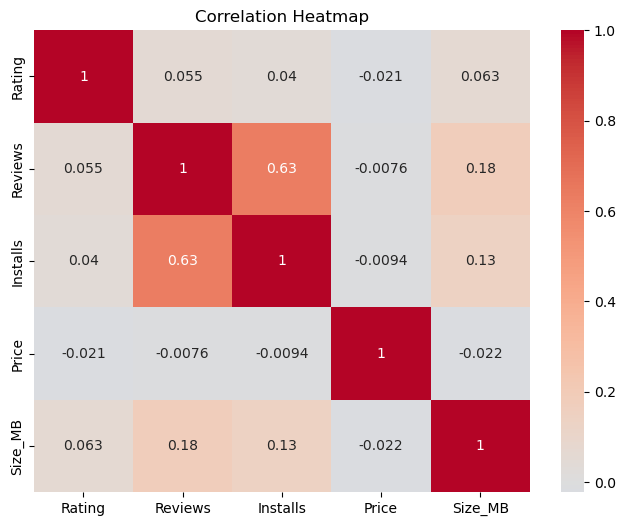

In [17]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['Rating','Reviews','Installs','Price','Size_MB']].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()


### Observation:
- `Reviews` and `Installs` are **highly correlated** (more installs → more reviews).  
- Ratings are **weakly correlated** with installs/reviews.  
- Price has almost no correlation with ratings or installs.  


# Step 17 – Final Insights

1. Google Play Store is dominated by **Free apps (92%)**.  
2. **Games, Communication, and Tools** lead in installs.  
3. Paid apps are rare and usually under **$20**.  
4. **Free apps attract far more installs** than paid ones.  
5. Ratings are skewed towards **4.0–5.0**, meaning users generally rate apps positively.  
6. Reviews and Installs are strongly correlated, but ratings don’t depend much on size or price.  
